# E-commerce Sales Analysis

---

**Author:** Alexandre Vechi maciel

**Email:** alexandre.vechim@gmail.com

**Date:** November 2025

**Case:** E-commerce Sales Analysis

**Important to Know:** I chose to use Google Colab for this solution due to its ease of setup and the convenience it offers for reviewers. Additionally, I am working with PySpark as it aligns directly with advanced SQL requirements. Since PySpark is based on Python, this also highlights my proficiency in the language and enables the creation of graphical visualizations.

## 1. Introduction

### Objective
 The primary goal is to analyze a dataset of E-Commerce sales transactions to identify key patterns, answer specific business questions, and provide recommendations based on the findings.

### Scope
The analysis is structured in two main phases:
1.  **Exploratory Data Analysis:** Answering fundamental questions about the data, such as average ticket, total sales by segment, top products, and user metrics.
2.  **Deep-Dive Analysis:** A more profound investigation into the target audience to identify the most valuable segments and an analysis of product category performance, culminating in product recommendations for the next year.

### How to Run This Notebook (Google Colab)
To reproduce this analysis, please follow these steps:

1.  **Environment:** This notebook is designed to run in Google Colab. A PySpark environment is set up in the initial cells.
2.  **Dependencies:** All required libraries (`PySpark`, `Pandas`, `Matplotlib`) are imported in the setup section.
3.  **Data Upload:** The first code cell will prompt you to upload the dataset. **Please upload the `dados.zip` file.** The notebook will automatically unzip and load the JSON files within it.
4.  **Execution:** Run the cells sequentially from top to bottom to ensure the SparkSession is initialized and the data transformations are applied correctly before the analysis queries are executed.

## 2. Initial Setup

### 2.1. Library Import and Data Upload

In [34]:
# Displays a button to upload local files
from google.colab import files
uploaded = files.upload()

Saving dados (2).zip to dados (2) (1).zip


In [35]:
# Import libraries needed to import the zip file
import zipfile
import os

# Import pandas and matplotlib libraries used in phase 2
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd

# Import necessary PySpark libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, sum as spark_sum, count, when, round, format_number, countDistinct

In [36]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip install pyspark==3.5.1  # Installing a specific compatible Spark version

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://cli.github.com/packages stable InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [37]:
# Creates a SparkSession, which is the entry point for working with data in PySpark
spark = SparkSession.builder \
    .appName("TesteContabilizei") \
    .getOrCreate()

In [38]:
# Path to the zip file that was uploaded
zip_path = "dados.zip"
extract_path = "dados_extraidos"

# Extract the contents of the zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

### 2.2. Initial Data Overview: Structure and Columns

First, let's load the data and examine its structure to understand the available columns and data types.

In [39]:
# Read the JSON files
df = spark.read.json(f"{extract_path}/*.json")

# Create a temporary view for SQL queries
df.createOrReplaceTempView("dados")

In [40]:
# Basic query
spark.sql("SELECT * FROM dados LIMIT 5").show()

+------------+------+-----+---------+-----------------+-------+-----+
|estado_civil|genero|idade|  produto|produto_categoria|usuario|valor|
+------------+------+-----+---------+-----------------+-------+-----+
|           0|     M|36-45|P00265242|                5|1001640| 8771|
|           0|     M|36-45|P00250342|               16|1001640| 8146|
|           0|     M|36-45|P00148542|                1|1001640| 7949|
|           0|     M|36-45|P00071242|                1|1001640|11506|
|           0|     M|26-35|P00363442|                1|1001641|15624|
+------------+------+-----+---------+-----------------+-------+-----+



In [41]:
# Print the schema (can be kept in API)
df.printSchema()

root
 |-- estado_civil: string (nullable = true)
 |-- genero: string (nullable = true)
 |-- idade: string (nullable = true)
 |-- produto: string (nullable = true)
 |-- produto_categoria: string (nullable = true)
 |-- usuario: string (nullable = true)
 |-- valor: string (nullable = true)



### 2.3. Data Transformation

Here we can note two important things:
1.  The need to convert the `valor` (value) column to a currency format (two decimal places) for easier analysis and visualization.
2.  We can assume that in `estado_civil` (marital status): `0 = Solteiro` (Single) and `1 = Casado` (Married).

Therefore, we will perform the conversion of these two columns below and save it as a new temporary view for our analyses. We can think of this as a CTE (Common Table Expression) if we were in a SQL database environment, using the same code for multiple analyses.

In [42]:
# Conversion of the 'valor' column
# Replaces the 0 and 1 codes with descriptive labels
spark.sql("""
CREATE OR REPLACE TEMP VIEW dados_tratados AS
SELECT
    usuario,
    idade,
    CASE
        WHEN estado_civil = 0 THEN 'Solteiro'
        WHEN estado_civil = 1 THEN 'Casado'
        ELSE 'Desconhecido'
    END AS estado_civil,
    produto,
    produto_categoria,
    ROUND(valor/100, 2) AS valor
FROM dados
""")

DataFrame[]

In [43]:
# Visualizing the created table
spark.sql("SELECT * FROM dados_tratados LIMIT 10").show()

+-------+-----+------------+---------+-----------------+------+
|usuario|idade|estado_civil|  produto|produto_categoria| valor|
+-------+-----+------------+---------+-----------------+------+
|1001640|36-45|    Solteiro|P00265242|                5| 87.71|
|1001640|36-45|    Solteiro|P00250342|               16| 81.46|
|1001640|36-45|    Solteiro|P00148542|                1| 79.49|
|1001640|36-45|    Solteiro|P00071242|                1|115.06|
|1001641|26-35|    Solteiro|P00363442|                1|156.24|
|1001641|26-35|    Solteiro|P00355142|                1| 190.0|
|1001641|26-35|    Solteiro|P00350442|                2|  66.3|
|1001641|26-35|    Solteiro|P00024742|                8| 98.23|
|1001641|26-35|    Solteiro|P00226942|               11| 17.15|
|1001641|26-35|    Solteiro|P00184942|                1|196.92|
+-------+-----+------------+---------+-----------------+------+



## 3. Phase 1: Exploratory Data Analysis

Now that the data is clean and transformed, we can answer the initial business questions.

### 1. What is the average sales ticket by age, ordered by age?
*The average ticket represents the average amount spent per order, in this case, by age.*

In [44]:
spark.sql("""
SELECT
    idade,
    ROUND(AVG(valor), 2) AS ticket_medio
FROM dados_tratados
GROUP BY idade
ORDER BY idade
""").show()

+-----+------------+
|idade|ticket_medio|
+-----+------------+
| 0-17|       89.33|
|18-25|        91.7|
|26-35|       92.53|
|36-45|       93.31|
|46-50|       92.09|
|51-55|       95.35|
|  55+|       93.36|
+-----+------------+



### 2. What is the total sales by age, ordered by total sales value?

In [45]:
# Here I had to use format_number to show the correct values without scientific notation
spark.sql("""
SELECT
    idade,
    FORMAT_NUMBER(SUM(valor), 2) AS total_vendas,
    COUNT(*) AS qtd_vendas
FROM dados_tratados
GROUP BY idade
ORDER BY SUM(valor) DESC
""").show()

+-----+-------------+----------+
|idade| total_vendas|qtd_vendas|
+-----+-------------+----------+
|26-35|20,317,705.78|    219587|
|36-45|10,265,698.84|    110013|
|18-25| 9,138,486.75|     99660|
|46-50| 4,208,434.03|     45701|
|51-55| 3,670,996.44|     38501|
|  55+| 2,007,673.75|     21504|
| 0-17| 1,349,131.83|     15102|
+-----+-------------+----------+



### 3. List the quantity of the top 10 best-selling products.

In [46]:
spark.sql("""
SELECT
    produto,
    COUNT(*) AS qtd_vendas
FROM dados_tratados
GROUP BY produto
ORDER BY qtd_vendas DESC
LIMIT 10
""").show()

+---------+----------+
|  produto|qtd_vendas|
+---------+----------+
|P00265242|      1880|
|P00025442|      1615|
|P00110742|      1612|
|P00112142|      1562|
|P00057642|      1470|
|P00184942|      1440|
|P00046742|      1438|
|P00058042|      1422|
|P00059442|      1406|
|P00145042|      1406|
+---------+----------+



### 4. How many unique users are in the database?

In [47]:
spark.sql("""
SELECT COUNT(DISTINCT usuario) AS usuarios_unicos
FROM dados_tratados
""").show()

+---------------+
|usuarios_unicos|
+---------------+
|           5891|
+---------------+



### 5. Extra Analysis: Unique users by age

In [48]:
spark.sql("""
SELECT
    idade,
    COUNT(DISTINCT usuario) AS usuarios_unicos
FROM dados_tratados
GROUP BY idade
""").show()

+-----+---------------+
|idade|usuarios_unicos|
+-----+---------------+
|18-25|           1069|
|26-35|           2053|
| 0-17|            218|
|46-50|            531|
|51-55|            481|
|36-45|           1167|
|  55+|            372|
+-----+---------------+



### 6. List the 10 users with the highest total sales.

In [49]:
spark.sql("""
SELECT
    usuario,
    ROUND(SUM(valor), 2) AS total_vendas
FROM dados_tratados
GROUP BY usuario
ORDER BY total_vendas DESC
LIMIT 10
""").show()

+-------+------------+
|usuario|total_vendas|
+-------+------------+
|1004277|   105369.09|
|1001680|    86995.96|
|1002909|    75777.56|
|1001941|    68174.93|
|1000424|    65736.09|
|1004448|    65662.45|
|1005831|    65124.33|
|1001015|    65113.14|
|1003391|     64771.6|
|1001181|    63879.61|
+-------+------------+



### 7. What percentage of total unique users does each age group represent?

In [50]:
# Here we use CTEs to separate the analyses, and at the end, we use a CROSS JOIN because the total_usuarios table has only one row
spark.sql("""
WITH usuarios_por_idade AS (
    SELECT
        idade,
        COUNT(DISTINCT usuario) AS usuarios_unicos_idade
    FROM dados_tratados
    GROUP BY idade
),
total_usuarios AS (
    SELECT COUNT(DISTINCT usuario) AS total
    FROM dados_tratados
)
SELECT
    u.idade,
    u.usuarios_unicos_idade,
    ROUND((u.usuarios_unicos_idade / t.total) * 100, 2) AS porcentagem
FROM usuarios_por_idade u
CROSS JOIN total_usuarios t
ORDER BY u.idade
""").show()

+-----+---------------------+-----------+
|idade|usuarios_unicos_idade|porcentagem|
+-----+---------------------+-----------+
| 0-17|                  218|        3.7|
|18-25|                 1069|      18.15|
|26-35|                 2053|      34.85|
|36-45|                 1167|      19.81|
|46-50|                  531|       9.01|
|51-55|                  481|       8.16|
|  55+|                  372|       6.31|
+-----+---------------------+-----------+



## 4. Phase 2: Deep-Dive Analysis

### 1. Target Audience Analysis

**Business Question:** The company needs to identify which audience had the most reach during Black Friday for a more targeted campaign next year. Considering the average ticket as a result, perform an analysis and describe which variable(s) are most important.

**Initial Finding:**
Right away, returning to the questions *"What is the total sales by age?"* and *"Unique users by age?"* from Phase 1, we can see that our largest audience, both in order quantity and revenue, are customers aged **26-35**. Furthermore, our unique customer base in this age group is approximately 50% larger (or more) compared to other age groups.

Below is a table by age group, which clarifies why the 26-35 age group is the most representative for the company.

In [51]:
spark.sql("""
WITH agregados AS (
    SELECT
        idade AS faixa_etaria,
        COUNT(DISTINCT usuario) AS usuarios_unicos,
        COUNT(*) AS total_pedidos,
        ROUND(SUM(valor), 2) AS faturamento
    FROM dados_tratados
    GROUP BY idade
),
totais AS (
    SELECT
        COUNT(DISTINCT usuario) AS total_usuarios,
        COUNT(*) AS total_pedidos_geral,
        SUM(valor) AS total_faturamento_geral
    FROM dados_tratados
)
SELECT
    a.faixa_etaria,
    a.usuarios_unicos,
    ROUND((a.usuarios_unicos / t.total_usuarios) * 100, 2) AS perc_usuarios,
    a.total_pedidos,
    ROUND((a.total_pedidos / t.total_pedidos_geral) * 100, 2) AS perc_pedidos,
    FORMAT_NUMBER(a.faturamento, 2) AS faturamento,
    ROUND((a.faturamento / t.total_faturamento_geral) * 100, 2) AS perc_faturamento,
    ROUND(a.faturamento / a.total_pedidos, 2) AS ticket_medio
FROM agregados a
CROSS JOIN totais t
ORDER BY faixa_etaria
""").show(truncate=False)

+------------+---------------+-------------+-------------+------------+-------------+----------------+------------+
|faixa_etaria|usuarios_unicos|perc_usuarios|total_pedidos|perc_pedidos|faturamento  |perc_faturamento|ticket_medio|
+------------+---------------+-------------+-------------+------------+-------------+----------------+------------+
|0-17        |218            |3.7          |15102        |2.75        |1,349,131.83 |2.65            |89.33       |
|18-25       |1069           |18.15        |99660        |18.12       |9,138,486.75 |17.93           |91.7        |
|26-35       |2053           |34.85        |219587       |39.92       |20,317,705.78|39.87           |92.53       |
|36-45       |1167           |19.81        |110013       |20.0        |10,265,698.84|20.15           |93.31       |
|46-50       |531            |9.01         |45701        |8.31        |4,208,434.03 |8.26            |92.09       |
|51-55       |481            |8.16         |38501        |7.0         |3

Now, to break down the analysis further, let's include marital status and understand if it has a deep impact on our age groups.

In [52]:
spark.sql("""
WITH agregados AS (
    SELECT
        idade AS faixa_etaria,
        estado_civil,
        COUNT(DISTINCT usuario) AS usuarios_unicos,
        COUNT(*) AS total_pedidos,
        SUM(valor) AS faturamento
    FROM dados_tratados
    GROUP BY idade, estado_civil
),
totais AS (
    SELECT
        COUNT(DISTINCT usuario) AS total_usuarios,
        COUNT(*) AS total_pedidos_geral,
        SUM(valor) AS total_faturamento_geral
    FROM dados_tratados
)
SELECT
    a.faixa_etaria,
    a.estado_civil,
    a.usuarios_unicos,
    ROUND((a.usuarios_unicos / t.total_usuarios) * 100, 2) AS perc_usuarios,
    a.total_pedidos,
    ROUND((a.total_pedidos / t.total_pedidos_geral) * 100, 2) AS perc_pedidos,
    FORMAT_NUMBER(a.faturamento, 2) AS faturamento,
    ROUND((a.faturamento / t.total_faturamento_geral) * 100, 2) AS perc_faturamento,
    ROUND(a.faturamento / a.total_pedidos, 2) AS ticket_medio
FROM agregados a
CROSS JOIN totais t
ORDER BY faixa_etaria, estado_civil
""").show(truncate=False)

+------------+------------+---------------+-------------+-------------+------------+-------------+----------------+------------+
|faixa_etaria|estado_civil|usuarios_unicos|perc_usuarios|total_pedidos|perc_pedidos|faturamento  |perc_faturamento|ticket_medio|
+------------+------------+---------------+-------------+-------------+------------+-------------+----------------+------------+
|0-17        |Solteiro    |218            |3.7          |15102        |2.75        |1,349,131.83 |2.65            |89.33       |
|18-25       |Casado      |244            |4.14         |21116        |3.84        |1,899,280.73 |3.73            |89.95       |
|18-25       |Solteiro    |825            |14.0         |78544        |14.28       |7,239,206.02 |14.21           |92.17       |
|26-35       |Casado      |809            |13.73        |86291        |15.69       |7,984,404.76 |15.67           |92.53       |
|26-35       |Solteiro    |1244           |21.12        |133296       |24.23       |12,333,301.02

**Key Finding:**

Here we can already notice something quite important: **single individuals in the 26-35 age group** represent more than 1/5 (21.12%) of our total user base. Additionally, the orders and revenue from this group represent almost **25% of the company's total Black Friday sales**.

Therefore, so far we have: **26-35 (General Audience) > 26-35 Singles (Most Relevant Subgroup)**.

But for future campaigns, we cannot overlook these groups:
* 18-25 Single
* 26-35 Married
* 36-45 Single

Together, these groups represent over 40% of the customer base and revenue!

Now, delving deeper into the analysis, I'd like to better understand which product category was most purchased by these highlighted age groups, and what percentage this represents of the total purchase value.

In [53]:
spark.sql("""
WITH filtrado AS (
    SELECT *
    FROM dados_tratados
    WHERE
        (idade = '26-35' AND estado_civil = 'Solteiro') OR
        (idade = '18-25' AND estado_civil = 'Solteiro') OR
        (idade = '26-35' AND estado_civil = 'Casado') OR
        (idade = '36-45' AND estado_civil = 'Solteiro')
),
pedidos_por_grupo_categoria AS (
    SELECT
        idade AS faixa_etaria,
        estado_civil,
        produto_categoria,
        COUNT(*) AS qtd_pedidos_categoria,
        SUM(valor) AS faturamento_categoria
    FROM filtrado
    GROUP BY idade, estado_civil, produto_categoria
),
total_pedidos_por_categoria AS (
    SELECT
        produto_categoria,
        COUNT(*) AS total_categoria
    FROM filtrado
    GROUP BY produto_categoria
),
total_pedidos_por_grupo AS (
    SELECT
        idade,
        estado_civil,
        COUNT(*) AS total_grupo,
        SUM(valor) AS faturamento_grupo
    FROM filtrado
    GROUP BY idade, estado_civil
)
SELECT
    p.faixa_etaria,
    p.estado_civil,
    p.produto_categoria,
    p.qtd_pedidos_categoria,
    FORMAT_NUMBER(p.faturamento_categoria, 2) AS faturamento_categoria,
    ROUND(p.faturamento_categoria / p.qtd_pedidos_categoria, 2) AS ticket_medio,
    ROUND((p.qtd_pedidos_categoria / c.total_categoria) * 100, 2) AS perc_dentro_categoria,
    ROUND((p.qtd_pedidos_categoria / g.total_grupo) * 100, 2) AS perc_dentro_grupo,
    ROUND((p.faturamento_categoria / g.faturamento_grupo) * 100, 2) AS perc_faturamento_grupo
FROM pedidos_por_grupo_categoria p
LEFT JOIN total_pedidos_por_categoria c ON p.produto_categoria = c.produto_categoria
LEFT JOIN total_pedidos_por_grupo g ON p.faixa_etaria = g.idade AND p.estado_civil = g.estado_civil
ORDER BY p.faixa_etaria, p.estado_civil, perc_dentro_grupo DESC
""").show(300, truncate=False)

+------------+------------+-----------------+---------------------+---------------------+------------+---------------------+-----------------+----------------------+
|faixa_etaria|estado_civil|produto_categoria|qtd_pedidos_categoria|faturamento_categoria|ticket_medio|perc_dentro_categoria|perc_dentro_grupo|perc_faturamento_grupo|
+------------+------------+-----------------+---------------------+---------------------+------------+---------------------+-----------------+----------------------+
|18-25       |Solteiro    |5                |22171                |1,366,486.53         |61.63       |21.93                |28.23            |18.88                 |
|18-25       |Solteiro    |1                |21751                |2,920,512.79         |134.27      |22.37                |27.69            |40.34                 |
|18-25       |Solteiro    |8                |14027                |1,038,672.01         |74.05       |19.54                |17.86            |14.35                 |
|18-

With a quick visual analysis above, we can observe a constant among the age groups: **categories 1, 5, and 8** are the top 3 most purchased categories, with quantities and revenue significantly higher than other categories.

Category 5 is the most purchased by almost all age groups.

Therefore, let's filter for only these categories.

In [54]:
# Filter added in the first CTE
spark.sql("""
WITH filtrado AS (
    SELECT *
    FROM dados_tratados
    WHERE
        produto_categoria IN (1, 5, 8) AND
        (
            (idade = '26-35' AND estado_civil = 'Solteiro') OR
            (idade = '18-25' AND estado_civil = 'Solteiro') OR
            (idade = '26-35' AND estado_civil = 'Casado') OR
            (idade = '36-45' AND estado_civil = 'Solteiro')
        )
),
pedidos_por_grupo_categoria AS (
    SELECT
        idade AS faixa_etaria,
        estado_civil,
        produto_categoria,
        COUNT(*) AS qtd_pedidos_categoria,
        SUM(valor) AS faturamento_categoria
    FROM filtrado
    GROUP BY idade, estado_civil, produto_categoria
),
total_pedidos_por_categoria AS (
    SELECT
        produto_categoria,
        COUNT(*) AS total_categoria
    FROM filtrado
    GROUP BY produto_categoria
),
total_pedidos_por_grupo AS (
    SELECT
        idade,
        estado_civil,
        COUNT(*) AS total_grupo,
        SUM(valor) AS faturamento_grupo
    FROM filtrado
    GROUP BY idade, estado_civil
)
SELECT
    p.faixa_etaria,
    p.estado_civil,
    p.produto_categoria,
    p.qtd_pedidos_categoria,
    FORMAT_NUMBER(p.faturamento_categoria, 2) AS faturamento_categoria,
    ROUND(p.faturamento_categoria / p.qtd_pedidos_categoria, 2) AS ticket_medio,
    ROUND((p.qtd_pedidos_categoria / c.total_categoria) * 100, 2) AS perc_dentro_categoria,
    ROUND((p.qtd_pedidos_categoria / g.total_grupo) * 100, 2) AS perc_dentro_grupo,
    ROUND((p.faturamento_categoria / g.faturamento_grupo) * 100, 2) AS perc_faturamento_grupo
FROM pedidos_por_grupo_categoria p
LEFT JOIN total_pedidos_por_categoria c ON p.produto_categoria = c.produto_categoria
LEFT JOIN total_pedidos_por_grupo g ON p.faixa_etaria = g.idade AND p.estado_civil = g.estado_civil
ORDER BY p.produto_categoria, p.faixa_etaria, perc_dentro_grupo DESC
""").show(truncate=False)

+------------+------------+-----------------+---------------------+---------------------+------------+---------------------+-----------------+----------------------+
|faixa_etaria|estado_civil|produto_categoria|qtd_pedidos_categoria|faturamento_categoria|ticket_medio|perc_dentro_categoria|perc_dentro_grupo|perc_faturamento_grupo|
+------------+------------+-----------------+---------------------+---------------------+------------+---------------------+-----------------+----------------------+
|18-25       |Solteiro    |1                |21751                |2,920,512.79         |134.27      |22.37                |37.53            |54.84                 |
|26-35       |Casado      |1                |23269                |3,123,304.11         |134.23      |23.93                |36.39            |53.55                 |
|26-35       |Solteiro    |1                |34980                |4,714,830.48         |134.79      |35.98                |34.97            |51.94                 |
|36-

**Category Finding:**

Now analyzing the table above, we can see that although **category 5** leads in sales volume, the average ticket and total revenue of **category 1** are much higher, showing that this category is much more profitable. Furthermore, in all analyzed groups, it concentrates more than 50% of the total revenue, even without leading in order volume.

Thus, if we are thinking about maximizing revenue and margin, we should focus on **category 1**. But in future strategies, we can use category 5 as an entry point for product 1.

Therefore, so far we have: **26-35 (General Audience) > 26-35 Singles (Most Relevant Subgroup) > Product Category 1.**

Finally, let's drill down to our final level: the products. Filtering the top 3 products.

In [55]:
spark.sql("""
WITH filtrado AS (
    SELECT *
    FROM dados_tratados
    WHERE
        produto_categoria IN (1, 5, 8) AND
        (
            (idade = '26-35' AND estado_civil = 'Solteiro') OR
            (idade = '18-25' AND estado_civil = 'Solteiro') OR
            (idade = '26-35' AND estado_civil = 'Casado') OR
            (idade = '36-45' AND estado_civil = 'Solteiro')
        )
),
pedidos_por_produto AS (
    SELECT
        idade AS faixa_etaria,
        estado_civil,
        produto_categoria,
        produto,
        COUNT(*) AS qtd_pedidos,
        SUM(valor) AS faturamento
    FROM filtrado
    GROUP BY idade, estado_civil, produto_categoria, produto
),
total_por_categoria_grupo AS (
    SELECT
        idade,
        estado_civil,
        produto_categoria,
        COUNT(*) AS total_categoria
    FROM filtrado
    GROUP BY idade, estado_civil, produto_categoria
),
total_por_grupo AS (
    SELECT
        idade,
        estado_civil,
        COUNT(*) AS total_grupo
    FROM filtrado
    GROUP BY idade, estado_civil
),
produto_ranked AS (
    SELECT
        p.faixa_etaria,
        p.estado_civil,
        p.produto_categoria,
        p.produto,
        p.qtd_pedidos,
        p.faturamento,
        c.total_categoria,
        g.total_grupo,
        ROW_NUMBER() OVER (
            PARTITION BY p.faixa_etaria, p.estado_civil, p.produto_categoria
            ORDER BY p.qtd_pedidos DESC
        ) AS rank
    FROM pedidos_por_produto p
    LEFT JOIN total_por_categoria_grupo c
        ON p.faixa_etaria = c.idade AND p.estado_civil = c.estado_civil AND p.produto_categoria = c.produto_categoria
    LEFT JOIN total_por_grupo g
        ON p.faixa_etaria = g.idade AND p.estado_civil = g.estado_civil
)
SELECT
    faixa_etaria,
    estado_civil,
    produto_categoria,
    produto,
    qtd_pedidos,
    FORMAT_NUMBER(faturamento, 2) AS faturamento,
    ROUND(faturamento / qtd_pedidos, 2) AS ticket_medio,
    ROUND((qtd_pedidos / total_categoria) * 100, 2) AS perc_categoria,
    ROUND((qtd_pedidos / total_grupo) * 100, 2) AS perc_grupo
FROM produto_ranked
WHERE rank <= 3
ORDER BY faixa_etaria, estado_civil, produto_categoria, qtd_pedidos DESC
""").show(1000, truncate=False)

+------------+------------+-----------------+---------+-----------+-----------+------------+--------------+----------+
|faixa_etaria|estado_civil|produto_categoria|produto  |qtd_pedidos|faturamento|ticket_medio|perc_categoria|perc_grupo|
+------------+------------+-----------------+---------+-----------+-----------+------------+--------------+----------+
|18-25       |Solteiro    |1                |P00112142|266        |43,841.99  |164.82      |1.22          |0.46      |
|18-25       |Solteiro    |1                |P00110742|257        |44,199.90  |171.98      |1.18          |0.44      |
|18-25       |Solteiro    |1                |P00237542|239        |40,635.33  |170.02      |1.1           |0.41      |
|18-25       |Solteiro    |5                |P00265242|297        |23,418.93  |78.85       |1.34          |0.51      |
|18-25       |Solteiro    |5                |P00117442|205        |13,909.12  |67.85       |0.92          |0.35      |
|18-25       |Solteiro    |5                |P00

**Product Finding:**

Analyzing the data above, we can see that there isn't one dominant product across categories and age groups. Therefore, a campaign targeted at a specific product would not have a massive impact. **It makes more sense to have a campaign targeted at categories.**

### Final Answer: Target Audience

Based on the analyses performed, we identified that the audience with the greatest reach during Black Friday was composed of **users aged 26 to 35**, with an emphasis on **single individuals**.

This group stood out for having a large volume of orders, high revenue, and a competitive average ticket, especially in **category 1**, which accounted for over 50% of this audience's revenue.

Considering the average ticket as the main performance metric, the variables that most influenced this audience's performance were **age group**, **marital status**, and **product category**.

### 2. Product Category Analysis

**Business Question:** In addition to the target audience, the company also needs to analyze sales by product category. Please analyze and demonstrate the rationale and a graph.

In [56]:
# Initial query
resultado_categoria = spark.sql("""
WITH totais AS (
    SELECT
        COUNT(*) AS total_pedidos,
        SUM(valor) AS total_faturamento
    FROM dados_tratados
)
SELECT
    dt.produto_categoria,
    COUNT(*) AS qtd_pedidos,
    FORMAT_NUMBER(SUM(dt.valor), 2) AS faturamento_formatado,
    SUM(dt.valor) AS faturamento,
    ROUND(AVG(dt.valor), 2) AS ticket_medio,
    ROUND((COUNT(*) / t.total_pedidos) * 100, 2) AS perc_pedidos,
    ROUND((SUM(dt.valor) / t.total_faturamento) * 100, 2) AS perc_faturamento
FROM dados_tratados dt
CROSS JOIN totais t
GROUP BY dt.produto_categoria, t.total_pedidos, t.total_faturamento
ORDER BY CAST(dt.produto_categoria AS INT)
""")

resultado_categoria.show(1000, truncate=False)

+-----------------+-----------+---------------------+-------------------+------------+------------+----------------+
|produto_categoria|qtd_pedidos|faturamento_formatado|faturamento        |ticket_medio|perc_pedidos|perc_faturamento|
+-----------------+-----------+---------------------+-------------------+------------+------------+----------------+
|1                |140378     |19,100,137.54        |1.910013753999994E7|136.06      |25.52       |37.48           |
|2                |23864      |2,685,161.86         |2685161.859999992  |112.52      |4.34        |5.27            |
|3                |20213      |2,040,847.13         |2040847.1299999964 |100.97      |3.67        |4.0             |
|4                |11753      |273,804.88           |273804.88000000047 |23.3        |2.14        |0.54            |
|5                |150933     |9,418,352.29         |9418352.289999906  |62.4        |27.44       |18.48           |
|6                |20466      |3,241,503.02         |3241503.020

#### 2.1. Graph: Revenue and Order Volume by Category

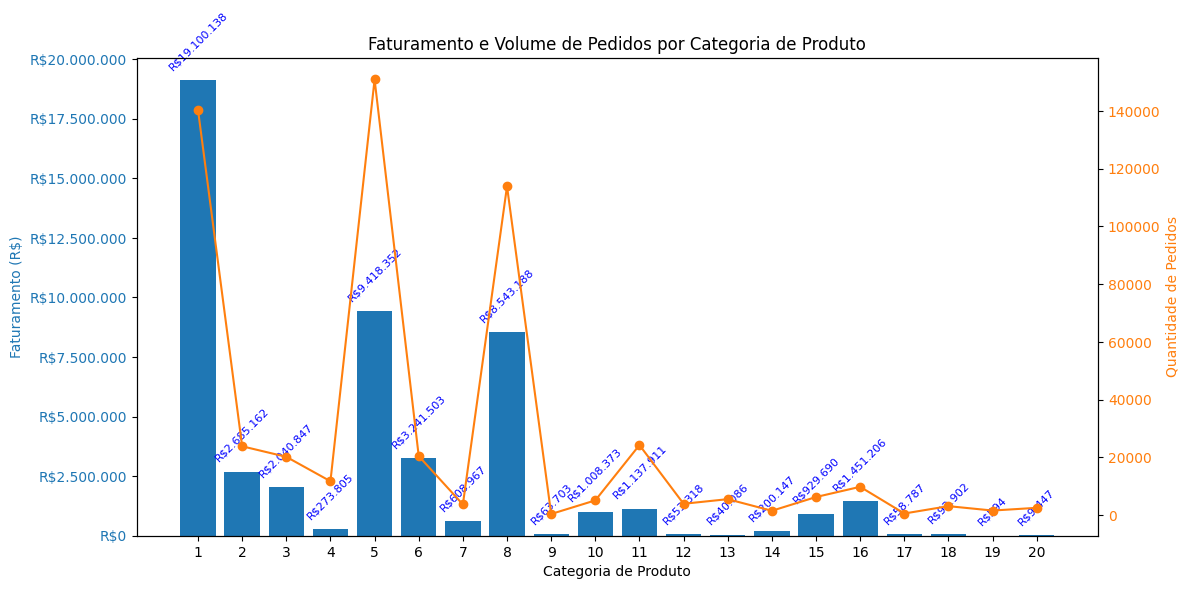

In [57]:
# The query is here again because when we use .show() in the query above, it doesn't store our result
resultado_categoria = spark.sql("""
WITH totais AS (
    SELECT
        COUNT(*) AS total_pedidos,
        SUM(valor) AS total_faturamento
    FROM dados_tratados
)
SELECT
    dt.produto_categoria,
    COUNT(*) AS qtd_pedidos,
    ROUND(SUM(dt.valor), 2) AS faturamento,
    ROUND(AVG(dt.valor), 2) AS ticket_medio,
    ROUND((COUNT(*) / t.total_pedidos) * 100, 2) AS perc_pedidos,
    ROUND((SUM(dt.valor) / t.total_faturamento) * 100, 2) AS perc_faturamento
FROM dados_tratados dt
CROSS JOIN totais t
GROUP BY dt.produto_categoria, t.total_pedidos, t.total_faturamento
ORDER BY CAST(dt.produto_categoria AS INT)
""")

# Convert to pandas
pdf = resultado_categoria.toPandas()
pdf['produto_categoria'] = pdf['produto_categoria'].astype(str)

# Create graph
fig, ax1 = plt.subplots(figsize=(12, 6))

# Revenue bars
bars = ax1.bar(pdf['produto_categoria'], pdf['faturamento'], color='tab:blue')
ax1.set_ylabel('Faturamento (R$)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'R${x:,.0f}'.replace(",", ".")))

# Rotated annotations
for bar in bars:
    height = bar.get_height()
    ax1.annotate(f'R${height:,.0f}'.replace(",", "."),
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 6),  # 6 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom',
                 fontsize=8, color='blue',
                 rotation=45)

# Order line
ax2 = ax1.twinx()
ax2.plot(pdf['produto_categoria'], pdf['qtd_pedidos'], color='tab:orange', marker='o')
ax2.set_ylabel('Quantidade de Pedidos', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Final touches
ax1.set_xlabel('Categoria de Produto')
plt.title('Faturamento e Volume de Pedidos por Categoria de Produto')
plt.tight_layout()
plt.show()

**Graph Rationale:**

Here I opted to use a combined bar and line chart because it allows me to compare two important pieces of information clearly and simultaneously: **revenue** (bars) and **order quantity** (line) by category.

With this, I can visualize which categories sold a lot but perhaps generated little revenue (e.g., category 5), or other categories that didn't sell as much but brought in high revenue (e.g., category 1).

#### 2.2. Graphs: Percentage of Revenue and Orders

I also decided to visualize the percentages of revenue and quantity by category in a pie chart format, and I chose to group the smaller categories (those with < 2% of the total) into an "Outros" (Others) slice to improve the graph's readability.

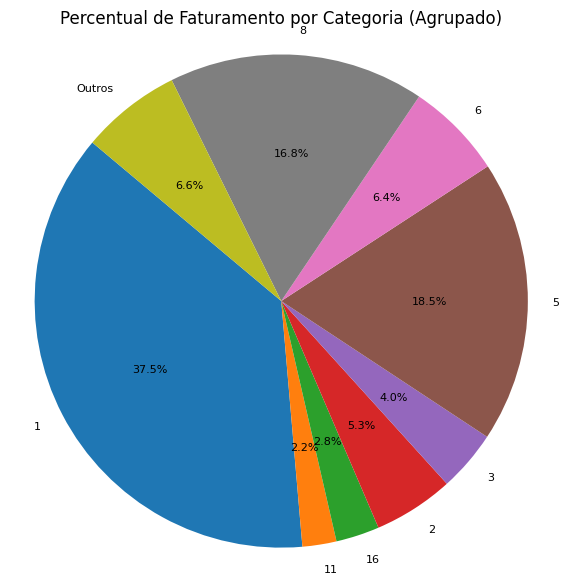

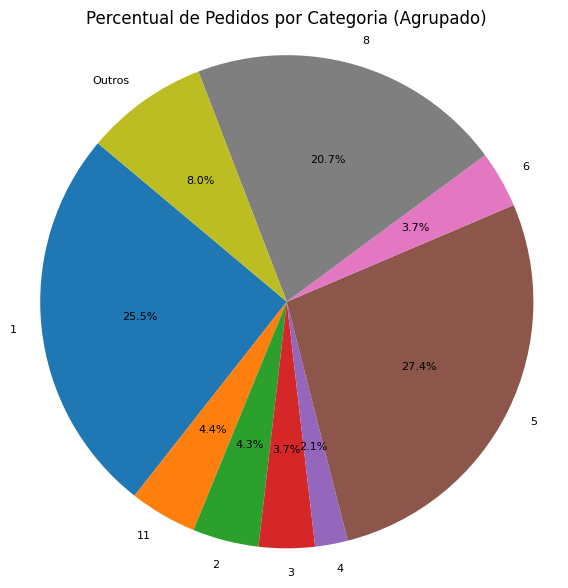

In [58]:
# Re-execute SQL query
resultado_categoria = spark.sql("""
WITH totais AS (
    SELECT
        COUNT(*) AS total_pedidos,
        SUM(valor) AS total_faturamento
    FROM dados_tratados
),
totais_completos AS (
    SELECT
        dt.produto_categoria,
        COUNT(*) AS qtd_pedidos,
        ROUND(SUM(dt.valor), 2) AS faturamento,
        ROUND(AVG(dt.valor), 2) AS ticket_medio,
        ROUND((COUNT(*) / t.total_pedidos) * 100, 2) AS perc_pedidos,
        ROUND((SUM(dt.valor) / t.total_faturamento) * 100, 2) AS perc_faturamento
    FROM dados_tratados dt
    CROSS JOIN totais t
    GROUP BY dt.produto_categoria, t.total_pedidos, t.total_faturamento
)
SELECT *
FROM totais_completos
ORDER BY CAST(produto_categoria AS INT)
""")

# Import and prepare data
import pandas as pd
import matplotlib.pyplot as plt

pdf = resultado_categoria.toPandas()
pdf['produto_categoria'] = pdf['produto_categoria'].astype(str)

# Percentage limit for grouping
limite_percentual = 2.0

# Group "Others" - Revenue
pdf_faturamento = pdf.copy()
pdf_faturamento['categoria'] = pdf_faturamento.apply(
    lambda row: row['produto_categoria'] if row['perc_faturamento'] >= limite_percentual else 'Outros',
    axis=1
)
faturamento_agrupado = pdf_faturamento.groupby('categoria').agg({
    'perc_faturamento': 'sum'
}).reset_index()

# Group "Others" - Orders
pdf_pedidos = pdf.copy()
pdf_pedidos['categoria'] = pdf_pedidos.apply(
    lambda row: row['produto_categoria'] if row['perc_pedidos'] >= limite_percentual else 'Outros',
    axis=1
)
pedidos_agrupado = pdf_pedidos.groupby('categoria').agg({
    'perc_pedidos': 'sum'
}).reset_index()

# Pie chart - Revenue
fig1, ax1 = plt.subplots(figsize=(7, 7))
ax1.pie(faturamento_agrupado['perc_faturamento'], labels=faturamento_agrupado['categoria'],
        autopct='%1.1f%%', startangle=140, textprops={'fontsize': 8})
ax1.set_title('Percentual de Faturamento por Categoria (Agrupado)')
ax1.axis('equal')

# Pie chart - Orders
fig2, ax2 = plt.subplots(figsize=(7, 7))
ax2.pie(pedidos_agrupado['perc_pedidos'], labels=pedidos_agrupado['categoria'],
        autopct='%1.1f%%', startangle=140, textprops={'fontsize': 8})
ax2.set_title('Percentual de Pedidos por Categoria (Agrupado)')
ax2.axis('equal')

plt.show()

### Final Answer: Category Analysis

Finally, with this analysis and these graphs, we can reiterate what we discovered in the target audience analysis: **categories 1, 5, and 8** are the categories with the highest sales volume and revenue.

* **Category 1** was responsible for **37.48% of the total revenue**, even though it only represented 25.52% of total orders. This confirms it is the company's **most profitable category**.
* **Category 5**, on the other hand, led in volume with 27.44% of orders but contributed 18.48% of the revenue.
* **Category 8** showed intermediate behavior, with 20.71% of sales volume and 16.77% of the revenue.

### 3. Product Recommendations

**Business Question:** Continuing the research for next year, please indicate the top 3 products you would recommend for sale next year and one 'wild card' (one to take a risk on) from the list. Describe the rationale.

**Rationale:**
Here, I understand we need to perform two different queries: one to find the **top products** (which I imagine are in categories 1, 5, and 8), and another for the **bottom products** (to find the 'wild card'). I will use the average ticket, revenue, and quantity values to define the top and bottom.

#### 3.1. Top 5 Products (from Categories 1, 5, 8)

In [59]:
resultado_top5_produtos = spark.sql("""
WITH filtrado AS (
    SELECT *
    FROM dados_tratados
    WHERE produto_categoria IN (1, 5, 8)
),
totais_categoria AS (
    SELECT
        produto_categoria,
        COUNT(*) AS total_pedidos_categoria,
        SUM(valor) AS total_faturamento_categoria
    FROM filtrado
    GROUP BY produto_categoria
),
agregados AS (
    SELECT
        f.produto,
        f.produto_categoria,
        COUNT(*) AS qtd_pedidos,
        ROUND(SUM(f.valor), 2) AS faturamento,
        ROUND(AVG(f.valor), 2) AS ticket_medio,
        tc.total_pedidos_categoria,
        tc.total_faturamento_categoria,
        ROUND(COUNT(*) / tc.total_pedidos_categoria * 100, 2) AS perc_categoria,
        ROUND(SUM(f.valor) / tc.total_faturamento_categoria * 100, 2) AS perc_faturamento_categoria
    FROM filtrado f
    JOIN totais_categoria tc
        ON f.produto_categoria = tc.produto_categoria
    GROUP BY f.produto, f.produto_categoria, tc.total_pedidos_categoria, tc.total_faturamento_categoria
),
ranqueado AS (
    SELECT *,
        ROW_NUMBER() OVER (PARTITION BY produto_categoria ORDER BY faturamento DESC) AS rank
    FROM agregados
)
SELECT
    produto,
    produto_categoria,
    qtd_pedidos,
    faturamento,
    ticket_medio,
    perc_categoria,
    perc_faturamento_categoria
FROM ranqueado
WHERE rank <= 5
ORDER BY produto_categoria, rank
""")

resultado_top5_produtos.show(truncate=False)

+---------+-----------------+-----------+-----------+------------+--------------+--------------------------+
|produto  |produto_categoria|qtd_pedidos|faturamento|ticket_medio|perc_categoria|perc_faturamento_categoria|
+---------+-----------------+-----------+-----------+------------+--------------+--------------------------+
|P00025442|1                |1615       |279951.66  |173.34      |1.15          |1.47                      |
|P00110742|1                |1612       |267223.09  |165.77      |1.15          |1.4                       |
|P00184942|1                |1440       |243348.87  |168.99      |1.03          |1.27                      |
|P00112142|1                |1562       |242160.06  |155.03      |1.11          |1.27                      |
|P00110942|1                |1360       |236395.64  |173.82      |0.97          |1.24                      |
|P00265242|5                |1880       |141655.15  |75.35       |1.25          |1.5                       |
|P00117942|5       

**Top 3 Rationale:**

Although in the initial analysis I considered one standout product from each of the three most relevant categories (1, 5, and 8), I believe it might be more strategic to focus only on the **Top 3 products from category 1**. This is because category 1 alone was responsible for over 37% of the total Black Friday revenue, with a high average ticket and more profitable products per sale.

However, if we want to diversify the catalog and provide entry points to category 1, categories 5 and 8 can be useful if we want a mix of products that generate volume and financial return.

But if the perspective is purely financial return, I would use the **top 3 products from category 1 (P00025442, P00110742, and P00184942)**.

#### 3.2. Bottom 5 Products / 'Wild Card' (from Categories 1, 5, 8)

Analysis of the Bottom 5 - I decided to first analyze the bottom 5 products from categories (1, 5, 8) to find the 'wild card' to risk.

In [60]:
spark.sql("""
WITH filtrado AS (
    SELECT *
    FROM dados_tratados
    WHERE produto_categoria IN (1, 5, 8)
),
agregados AS (
    SELECT
        produto,
        produto_categoria,
        COUNT(*) AS qtd_pedidos,
        ROUND(SUM(valor), 2) AS faturamento,
        ROUND(AVG(valor), 2) AS ticket_medio
    FROM filtrado
    GROUP BY produto, produto_categoria
),
ranqueado AS (
    SELECT *,
        ROW_NUMBER() OVER (
            PARTITION BY produto_categoria
            ORDER BY faturamento ASC
        ) AS rank
    FROM agregados
)
SELECT
    produto,
    produto_categoria,
    qtd_pedidos,
    faturamento,
    ticket_medio
FROM ranqueado
WHERE rank <= 5
ORDER BY produto_categoria, rank
""").show(1000, truncate=False)

+---------+-----------------+-----------+-----------+------------+
|produto  |produto_categoria|qtd_pedidos|faturamento|ticket_medio|
+---------+-----------------+-----------+-----------+------------+
|P00057842|1                |1          |41.79      |41.79       |
|P00211742|1                |1          |82.33      |82.33       |
|P00027842|1                |1          |121.28     |121.28      |
|P00206942|1                |1          |152.24     |152.24      |
|P00261942|1                |2          |154.02     |77.01       |
|P00012942|5                |1          |17.17      |17.17       |
|P00104042|5                |1          |17.45      |17.45       |
|P00357542|5                |1          |17.91      |17.91       |
|P00063442|5                |1          |18.66      |18.66       |
|P00107442|5                |1          |19.24      |19.24       |
|P00069742|8                |1          |19.77      |19.77       |
|P00013842|8                |1          |20.21      |20.21    

**'Wild Card' Rationale:**

Observing the data above, I believe the "worst of the worst" is **product P00012942 from category 5**, as it has the lowest average ticket and also the lowest revenue, in addition to an infinitesimal quantity of orders. This would be the 'wild card' to risk (or, more likely, to discontinue).

### Final Answer: Product Recommendations

Based on the analyses above:

1.  **Top 3 Products:** The top 3 products I would recommend for sale next year would be:
    * **P00025442** (Category 1)
    * **P00110742** (Category 1)
    * **P00184942** (Category 1)

2.  **'Wild Card' Product:** The one to take a risk on (or remove) from the list would be:
    * **P00012942** (Category 5)

### Phase 4: Presenting My Results

* * *

This final section summarizes the key findings and actionable recommendations derived from the E-commerce sales analysis.

#### 4.1 What I Found

The core challenge identified in this dataset was not a "problem" like fraud, but a massive, untapped **opportunity**. The company's Black Friday sales are highly concentrated, and this analysis uncovered a specific, high-value customer segment and a high-profit product category that drives a disproportionate amount of revenue.

The analysis revealed that the **26-35 age group** is the single most critical audience, generating nearly **40% of all company revenue** during this period.

Drilling down, the most valuable sub-segment is not just the 26-35 age group, but specifically **26-35 year-old singles**. This one cohort alone accounts for:
* **21.12%** of all unique users
* **~24.2%** of all orders
* **~24.2%** of total company revenue

This group is, without a doubt, the company's primary target audience.

#### 4.2 How I Identified These Patterns

My analysis was conducted in two main phases:

* **Phase 1 - The Baseline:** First, I loaded and transformed the raw JSON data, establishing the overall picture: **5,891 unique users** across 7 distinct age groups. I calculated baseline metrics for all segments, such as average ticket and total sales per age group.
* **Phase 2 - The Deep-Dive:**
  * **Customer Segmentation:** I segmented the data by `idade` (age) and `estado_civil` (marital status). This immediately revealed that while the 26-35 age group was the largest overall, the "Single" (Solteiro) customers within that group were the most significant cohort, dominating all key metrics.
  * **Product Performance:** I then analyzed product categories to see what this segment was buying. I found that sales are overwhelmingly concentrated in **Categories 1, 5, and 8**. These three categories dominate both sales volume and revenue, far surpassing all 17 other categories.

#### 4.3 What Stands Out Most

The most critical insight from this analysis is the "Profit vs. Volume" discovery. The company's best-selling category is **not** its most profitable.

* **Category 5 (The Volume Leader):** This category has the most sales, accounting for **27.44% of all orders**. However, it only generates **18.48% of total revenue**.
* **Category 1 (The Profit Leader):** This category is second in sales volume (25.52% of orders) but is the undisputed revenue champion, generating a massive **37.48% of all revenue**.

This discovery is key: Category 1 has a significantly higher average ticket price and is far more crucial for financial performance. **A strategy focused on Category 5 would grow order numbers, but a strategy focused on Category 1 will grow revenue.**

#### 4.4 What I Recommend

Based on these clear data patterns, my recommendations are focused and actionable:

1. **Target the "Profit Leaders" Audience:** Focus the primary marketing budget and campaign creative on the **26-35 year-old Single** demographic. This is the core audience.
2. **Prioritize Category 1 for Profit:** All primary marketing should be directed at promoting products from **Category 1**, as this is the proven, high-revenue category.
3. **Feature the "Top 3" Products:** Drive the campaign by specifically featuring the three highest-performing products from Category 1, which are: **P00025442, P00110742, and P00184942**.
4. **Use Category 5 as an Entry Point:** Leverage the popular, high-volume products from Category 5 as "door-openers" or in cross-selling strategies to acquire new customers and introduce them to the more profitable Category 1 products.

#### 4.5 The Bottom Line

This analysis identified a significant and clear opportunity for revenue growth. The company's sales are not random; they are driven by a specific, high-value customer segment and a highly profitable, distinct product category. The path forward is not to simply sell *more*, but to sell *smarter*. By shifting the marketing focus from pure volume (Category 5) to profit (Category 1), and targeting the 26-35 year-old Single demographic, the company can build a far more effective and profitable campaign for the next Black Friday event.